## 05 - Additional Features

Using Neural Networks on Times Series Forecasting is not limited to one time series. You can add other time series, maybe shifted ones and also other feature, which describes the target values. This notebook shows how this can be done

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier

seed=8172
np.random.seed(seed)
tf.random.set_seed(seed)
ts_input_size=12
ts_target_size=1
forecast_size=12
# Read the data
df=pd.read_csv("../data/AirPassengers.csv")
df.columns=["Period","Passengers"]




In [2]:
# Adding additional Features
df["Month"]=df.Period.str[5:].astype(int)
df["Year"]=df.Period.str[:4].astype(int)
df.head()

,Period,Passengers,Month,Year
0,1949-01,112,1,1949
1,1949-02,118,2,1949
2,1949-03,132,3,1949
3,1949-04,129,4,1949
4,1949-05,121,5,1949


In [3]:
# Scaling
dfTraining=df.iloc[:-forecast_size].copy()

scaler = MinMaxScaler(feature_range = (0.1, 0.9))
scalerMonth = MinMaxScaler(feature_range = (0.1, 0.9))
scalerYear = MinMaxScaler(feature_range = (0.1, 0.8))
series_scaled = scaler.fit_transform(dfTraining["Passengers"].values.reshape(-1,1))
series_scaled_month = scalerMonth.fit_transform(dfTraining["Month"].values.reshape(-1,1))
series_scaled_year = scalerYear.fit_transform(dfTraining["Year"].values.reshape(-1,1))
dfTraining["PassengersScaled"]=series_scaled
dfTraining["MonthScaled"]=series_scaled_month
dfTraining["YearScaled"]=series_scaled_year

dfTraining.head(15)

,Period,Passengers,Month,Year,PassengersScaled,MonthScaled,YearScaled
0,1949-01,112,1,1949,0.114066,0.100000,0.10
1,1949-02,118,2,1949,0.124615,0.172727,0.10
2,1949-03,132,3,1949,0.149231,0.245455,0.10
3,1949-04,129,4,1949,0.143956,0.318182,0.10
4,1949-05,121,5,1949,0.129890,0.390909,0.10
5,1949-06,135,6,1949,0.154505,0.463636,0.10
6,1949-07,148,7,1949,0.177363,0.536364,0.10
7,1949-08,148,8,1949,0.177363,0.609091,0.10
8,1949-09,136,9,1949,0.156264,0.681818,0.10
9,1949-10,119,10,1949,0.126374,0.754545,0.10


Now build the arrays for the observations

In [4]:
training_flat_passengers=dfTraining["PassengersScaled"].values.astype("float32")
training_flat_month=dfTraining["MonthScaled"].values.astype("float32")
training_flat_year=dfTraining["YearScaled"].values.astype("float32")
trainX=[]
trainY=[]
for i in range(len(training_flat_passengers)-ts_target_size-ts_input_size+1):
    x=[training_flat_month[i+ts_input_size],training_flat_year[i+ts_input_size]]
    x.extend(training_flat_passengers[i:(i+ts_input_size)])
    y=training_flat_passengers[(i+ts_input_size):(i+ts_input_size+ts_target_size)]
    trainX.append(x)
    trainY.append(y)


In [5]:
print(len(trainX),dfTraining.shape)
display(dfTraining.tail(14))
print("Last observation X: {}".format(trainX[-1]))
print("Last observation Y: {}".format(trainY[-1]))

120 (132, 7)


,Period,Passengers,Month,Year,PassengersScaled,MonthScaled,YearScaled
118,1958-11,310,11,1958,0.462198,0.827273,0.73
119,1958-12,337,12,1958,0.509670,0.900000,0.73
120,1959-01,360,1,1959,0.550110,0.100000,0.80
121,1959-02,342,2,1959,0.518462,0.172727,0.80
122,1959-03,406,3,1959,0.630989,0.245455,0.80
123,1959-04,396,4,1959,0.613407,0.318182,0.80
124,1959-05,420,5,1959,0.655604,0.390909,0.80
125,1959-06,472,6,1959,0.747033,0.463636,0.80
126,1959-07,548,7,1959,0.880659,0.536364,0.80
127,1959-08,559,8,1959,0.900000,0.609091,0.80


Last observation X: [0.9, 0.8, 0.5096703, 0.55010986, 0.5184615, 0.630989, 0.6134066, 0.6556044, 0.74703294, 0.88065934, 0.9, 0.7312088, 0.63274723, 0.55362636]
Last observation Y: [0.6292308]


In [6]:
# Training data
trainX=np.array(trainX)
trainY=np.array(trainY)
from sklearn.model_selection import train_test_split
x_trainbatches, x_testbatches, y_trainbatches, y_testbatches = train_test_split(
            trainX, trainY, test_size=0.1, random_state=42)

In [7]:
def show_loss(history,skipFirst=True):
    print("Last Results loss:{}, cross validation loss:{}".format(history.history['loss'][-1],history.history['val_loss'][-1]))
    plt.figure(figsize=(20,10))
    start=100 if skipFirst else 0
    plt.plot(history.history["val_loss"][start:], label="Cross Validation Loss")
    plt.plot(history.history["loss"][start:], label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Results - Training vs. Cross Validation (Mean Squared Error)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()  

def show_results(df,predictX,predictY):
    outputsize=len(predictY[0])
    inputsize=len(predictX[0])
    absDeviation=np.sum(np.abs(df["Passengers"].values[-outputsize:]-predictY[0]))
    absError=absDeviation/np.sum(predictY[0])*100
    print("          Forecast : {}\r\n            Actual : {}\r\nAbsolute Deviation : {} Passengers\r\n    Absolute Error : {:3.2f}%".format(
        predictY.astype(int)[0],df["Passengers"].values[-outputsize:],absDeviation,absError))    
    y0=df["Passengers"].values
    y1=[None for x in range(df.shape[0]-outputsize-inputsize)]
    y1.extend(predictX[0])
    y1=np.array(y1)
    y2=[None for x in range(df.shape[0]-outputsize)]
    y2.extend(predictY[0])
    y2=np.array(y2)
    plt.figure(figsize=(20,10))
    plt.plot(y0,label='Actual')
    plt.plot(y1,label='Input for Forecast')
    plt.plot(y2, label= 'Forecast')
    plt.xlabel("Period")
    labels=[df["Period"].iloc[x] for x in range(0,df.shape[0],12)]
    plt.xticks(range(0,df.shape[0],12),labels=labels, rotation=45)
    plt.ylabel("Number of Passenger")
    plt.title("Forecast Airline Passenger")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()    


def buildAndTrainModel(layerSize1,layerSize2,x_trainbatches, x_testbatches, y_trainbatches, y_testbatches, usebias=True):
    model=keras.Sequential()
    model.add(keras.layers.Dense(layerSize1,activation=keras.layers.LeakyReLU(), input_dim=len(x_trainbatches[0]), use_bias=usebias))
    if layerSize2 is not None:
        model.add(keras.layers.Dense(layerSize2,activation=keras.layers.LeakyReLU(), use_bias=usebias))
    model.add(keras.layers.Dense(ts_target_size, activation=keras.layers.LeakyReLU(), use_bias=usebias))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )
    earlyStopCB= keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=300,verbose=0,mode='auto')
    history=model.fit(x_trainbatches, y_trainbatches, epochs=10000,verbose=0,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               use_multiprocessing=True, callbacks=[earlyStopCB])
    return model,history




In [8]:
model,history=buildAndTrainModel(67,13,x_trainbatches, x_testbatches, y_trainbatches, y_testbatches,True)

Last Results loss:0.00024161186593119055, cross validation loss:0.0005910141044296324


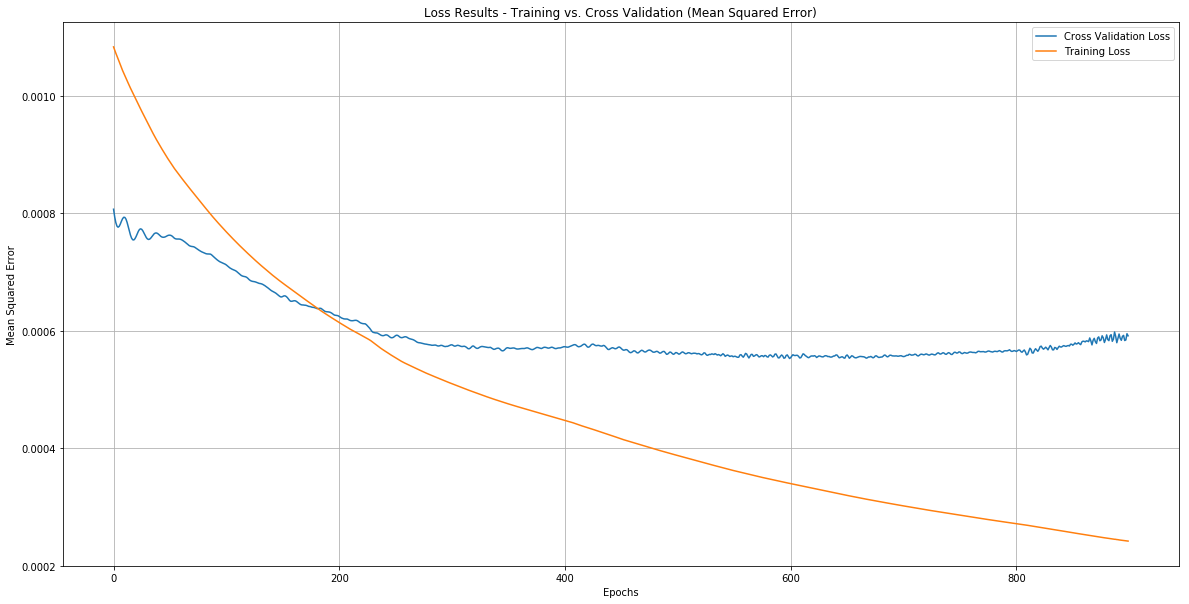

In [9]:
show_loss(history)

Loop 0: Input: [[0.1        0.87       0.55010986 0.5184615  0.630989   0.6134066
  0.6556044  0.74703294 0.88065934 0.9        0.7312088  0.63274723
  0.55362636 0.6292308 ]] --> Result: [[0.6306895]]
Loop 1: Input: [[0.17272727 0.87       0.5184615  0.630989   0.6134066  0.6556044
  0.74703294 0.88065934 0.9        0.7312088  0.63274723 0.55362636
  0.6292308  0.6306895 ]] --> Result: [[0.58006585]]
Loop 2: Input: [[0.24545455 0.87       0.630989   0.6134066  0.6556044  0.74703294
  0.88065934 0.9        0.7312088  0.63274723 0.55362636 0.6292308
  0.6306895  0.58006585]] --> Result: [[0.6762695]]
Loop 3: Input: [[0.3181818  0.87       0.6134066  0.6556044  0.74703294 0.88065934
  0.9        0.7312088  0.63274723 0.55362636 0.6292308  0.6306895
  0.58006585 0.6762695 ]] --> Result: [[0.67598826]]
Loop 4: Input: [[0.3909091  0.87       0.6556044  0.74703294 0.88065934 0.9
  0.7312088  0.63274723 0.55362636 0.6292308  0.6306895  0.58006585
  0.6762695  0.67598826]] --> Result: [[0.6957

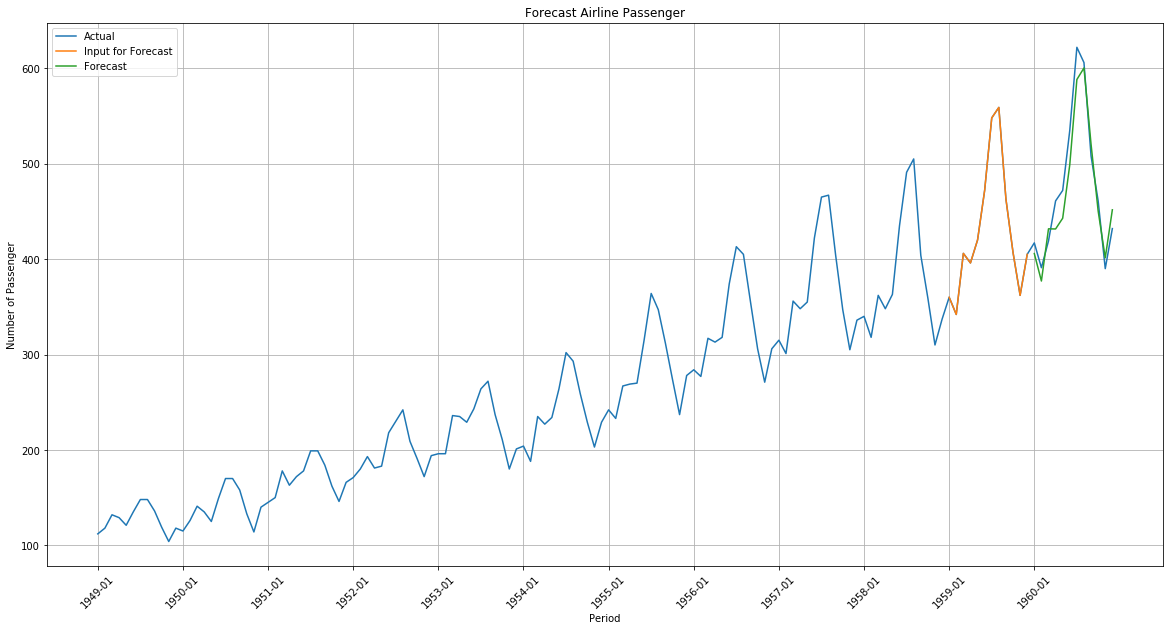

In [10]:
def predict(model,predictPassengersX,futureListMonthX,futureListYearX,forecast_size):
    result=None
    predictInputPassengers=np.array(predictPassengersX)
    for loop in range(0,forecast_size):
        predictInput=np.reshape(np.append([futureListMonthX[0,loop],futureListYearX[0,loop]],predictInputPassengers[0]),(1,-1))
        predictOutput=model.predict(predictInput)
        print("Loop {}: Input: {} --> Result: {}".format(loop,predictInput,predictOutput))
        result=predictOutput if result is None else np.append(result,predictOutput)
        predictInputPassengers=np.reshape(np.append(predictInputPassengers[-1,1:],predictOutput),(1,-1))
    return np.reshape(result,(1,-1))

futureListMonthX=scalerMonth.transform(np.reshape(df.Month.values[-forecast_size:],(1,-1))).astype("float32")
futureListYearX=scalerYear.transform(np.reshape(df.Year.values[-forecast_size:],(1,-1))).astype("float32")
passengersX=np.reshape(training_flat_passengers[-ts_input_size:] ,(1,-1)) 
predictY=predict(model,passengersX,futureListMonthX,futureListYearX,forecast_size)
print("\r\nChart")
show_results(df,scaler.inverse_transform(passengersX),scaler.inverse_transform(predictY))  

Adding additional features in this case does not raise the accuracy. If not sure about, what's the influence of a feature is, check it with a feature selection functionality. 

To solve this I use the ExtraTreesClassifier from the scikit-learn module. This is a classifier base on random forests and you can get out of this a feature importance. 

First, I set up a the data for all the features, which I think, they should be inside the training

In [11]:
columns=["Month","Year"]
columns.extend(["Passengers-"+str(x)for x in(range(12,0,-1))])
dfTransposed=pd.DataFrame(trainX,columns=columns)
dfTransposed["Passengers-0"]=trainY
dfTransposed.head(5)

,Month,Year,Passengers-12,Passengers-11,Passengers-10,Passengers-9,Passengers-8,Passengers-7,Passengers-6,Passengers-5,Passengers-4,Passengers-3,Passengers-2,Passengers-1,Passengers-0
0,0.100000,0.17,0.114066,0.124615,0.149231,0.143956,0.129890,0.154505,0.177363,0.177363,0.156264,0.126374,0.100000,0.124615,0.119341
1,0.172727,0.17,0.124615,0.149231,0.143956,0.129890,0.154505,0.177363,0.177363,0.156264,0.126374,0.100000,0.124615,0.119341,0.138681
2,0.245455,0.17,0.149231,0.143956,0.129890,0.154505,0.177363,0.177363,0.156264,0.126374,0.100000,0.124615,0.119341,0.138681,0.165055
3,0.318182,0.17,0.143956,0.129890,0.154505,0.177363,0.177363,0.156264,0.126374,0.100000,0.124615,0.119341,0.138681,0.165055,0.154505
4,0.390909,0.17,0.129890,0.154505,0.177363,0.177363,0.156264,0.126374,0.100000,0.124615,0.119341,0.138681,0.165055,0.154505,0.136923


Next, prepare the target. As this is a classifier, I make classified series from the target feature.

In [12]:
targetFeature=pd.Series(pd.cut(dfTransposed["Passengers-0"],200,labels=False))
targetFeature

0        0
1        5
2       12
3        9
4        4
      ... 
115    199
116    156
117    131
118    111
119    130
Name: Passengers-0, Length: 120, dtype: int64

Now build a function which shows the feature importance of a feature combination. As there is a random forest used we also can show standard deviation of the importances per feature

In [13]:

def report_feature_importants(y,names,df):
    model = ExtraTreesClassifier()
    x=df[names].values
    model.fit(x, y)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    df=pd.DataFrame(model.feature_importances_,columns=["Importance"])
    df["Standard Deviation"]=std
    df["Feature"]=names
    df=df.sort_values(['Importance'], ascending=False)
    display(df)    
    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(20,10))
    plt.title("Feature importances")
    plt.bar(range(x.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
    plt.xticks(range(x.shape[1]),df["Feature"],rotation=45)
    plt.xlim([-1, x.shape[1]])
    plt.grid(True)
    plt.show()
    return model

,Importance,Standard Deviation,Feature
2,0.092582,0.029650,Passengers-12
3,0.081781,0.025625,Passengers-11
5,0.078062,0.030512,Passengers-9
12,0.076032,0.027532,Passengers-2
13,0.075544,0.023857,Passengers-1
9,0.073195,0.024846,Passengers-5
7,0.072359,0.024513,Passengers-7
4,0.069468,0.027863,Passengers-10
11,0.069255,0.023748,Passengers-3
10,0.066205,0.023694,Passengers-4


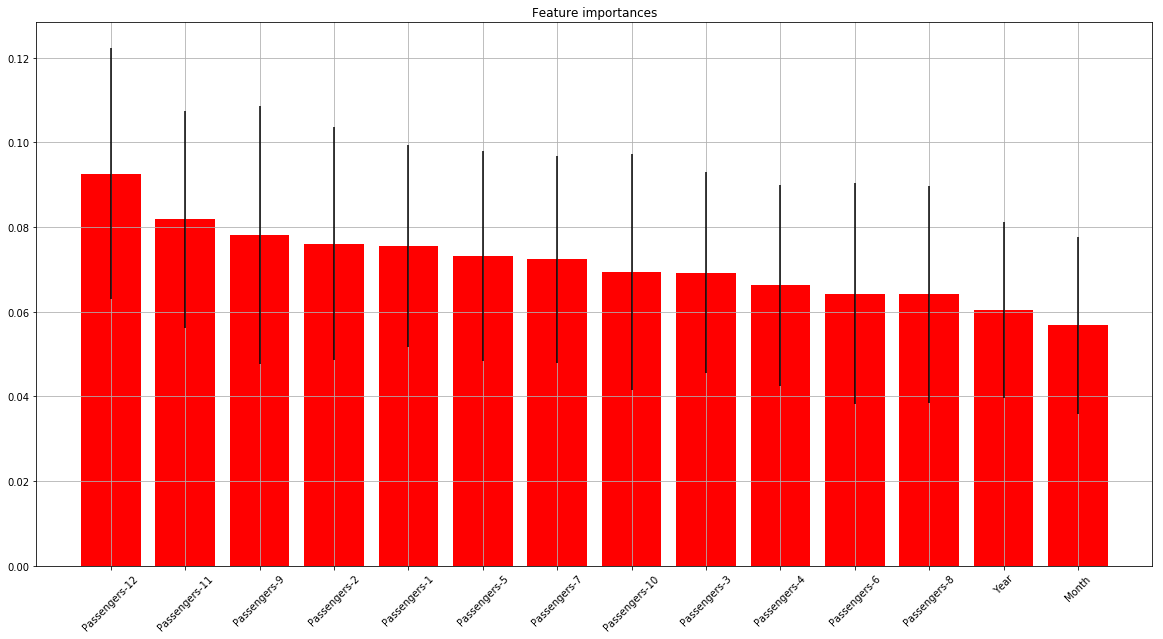

ExtraTreesClassifier()

In [14]:
report_feature_importants(targetFeature,columns,dfTransposed)

The chart above confirms what can be seen on the results of the last model. The month and the year feature have the lowest importance. But it is also interesting that not all periods have the same importance for the result. So let's make a try and reduce some features 

,Importance,Standard Deviation,Feature
0,0.278495,0.037529,Passengers-12
1,0.241826,0.040253,Passengers-11
3,0.241247,0.043259,Passengers-1
2,0.238432,0.035721,Passengers-2


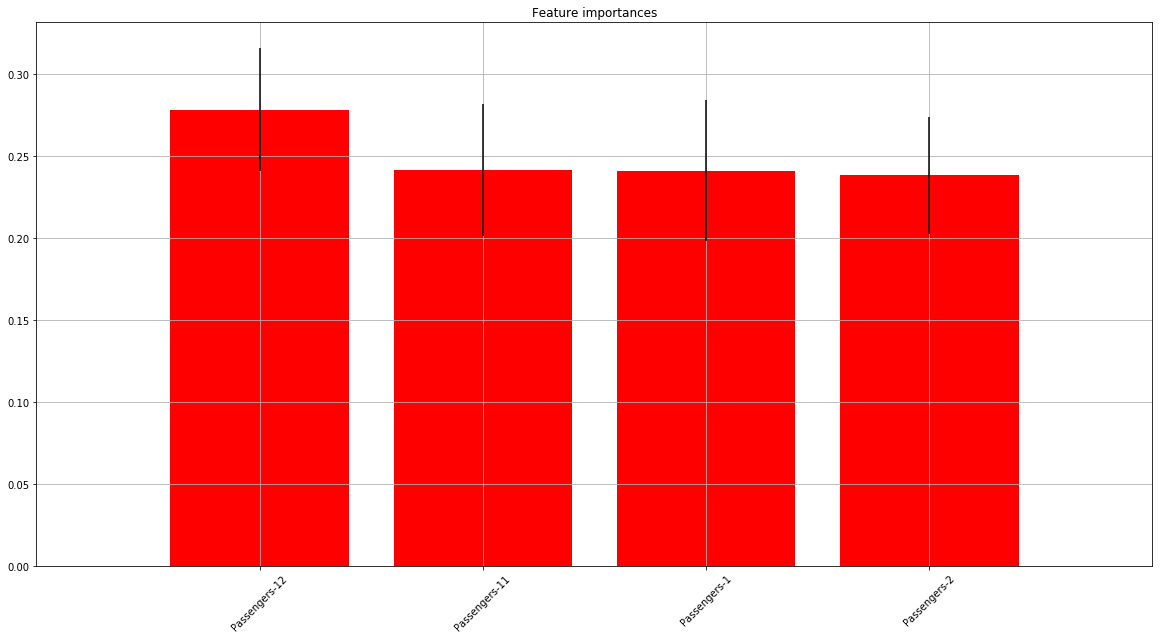

ExtraTreesClassifier()

In [15]:
columns2=["Passengers-12","Passengers-11","Passengers-2","Passengers-1"]
report_feature_importants(targetFeature,columns2,dfTransposed)

In [16]:
trainX2=dfTransposed[columns2].values
trainX2

array([[0.11406594, 0.12461539, 0.1       , 0.12461539],
       [0.12461539, 0.14923076, 0.12461539, 0.11934066],
       [0.14923076, 0.14395605, 0.11934066, 0.13868132],
       [0.14395605, 0.12989011, 0.13868132, 0.16505495],
       [0.12989011, 0.15450549, 0.16505495, 0.15450549],
       [0.15450549, 0.17736264, 0.15450549, 0.13692307],
       [0.17736264, 0.17736264, 0.13692307, 0.17912088],
       [0.17736264, 0.15626374, 0.17912088, 0.21604395],
       [0.15626374, 0.12637363, 0.21604395, 0.21604395],
       [0.12637363, 0.1       , 0.21604395, 0.19494505],
       [0.1       , 0.12461539, 0.19494505, 0.15098901],
       [0.12461539, 0.11934066, 0.15098901, 0.11758242],
       [0.11934066, 0.13868132, 0.11758242, 0.1632967 ],
       [0.13868132, 0.16505495, 0.1632967 , 0.17208791],
       [0.16505495, 0.15450549, 0.17208791, 0.18087912],
       [0.15450549, 0.13692307, 0.18087912, 0.23010989],
       [0.13692307, 0.17912088, 0.23010989, 0.20373626],
       [0.17912088, 0.21604395,

Last Results loss:0.0006515751592814922, cross validation loss:0.0003409549535717815


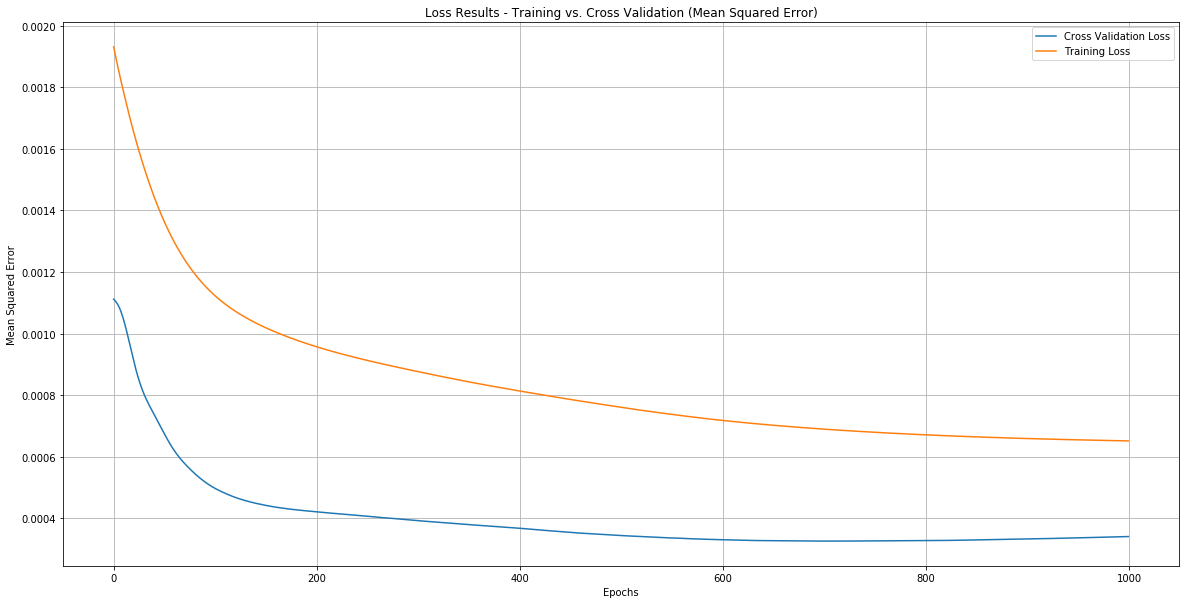

In [17]:
x_trainbatches2, x_testbatches2, y_trainbatches2, y_testbatches2 = train_test_split(
            trainX2, trainY, test_size=0.1, random_state=42)
model2,history2=buildAndTrainModel(67,13,x_trainbatches2, x_testbatches2, y_trainbatches2, y_testbatches2,True)
show_loss(history2)

Loop 0: Input: [[0.55010986 0.5184615  0.55362636 0.6292308 ]] --> Result: [[0.6262549]]
Loop 1: Input: [[0.5184615 0.630989  0.6292308 0.6262549]] --> Result: [[0.60742843]]
Loop 2: Input: [[0.630989   0.6134066  0.6262549  0.60742843]] --> Result: [[0.6820332]]
Loop 3: Input: [[0.6134066  0.6556044  0.60742843 0.6820332 ]] --> Result: [[0.6988109]]
Loop 4: Input: [[0.6556044  0.74703294 0.6820332  0.6988109 ]] --> Result: [[0.7374803]]
Loop 5: Input: [[0.74703294 0.88065934 0.6988109  0.7374803 ]] --> Result: [[0.8254432]]
Loop 6: Input: [[0.88065934 0.9        0.7374803  0.8254432 ]] --> Result: [[0.9479189]]
Loop 7: Input: [[0.9       0.7312088 0.8254432 0.9479189]] --> Result: [[0.9759654]]
Loop 8: Input: [[0.7312088  0.63274723 0.9479189  0.9759654 ]] --> Result: [[0.8376193]]
Loop 9: Input: [[0.63274723 0.55362636 0.9759654  0.8376193 ]] --> Result: [[0.7119764]]
Loop 10: Input: [[0.55362636 0.6292308  0.8376193  0.7119764 ]] --> Result: [[0.64134336]]
Loop 11: Input: [[0.629230

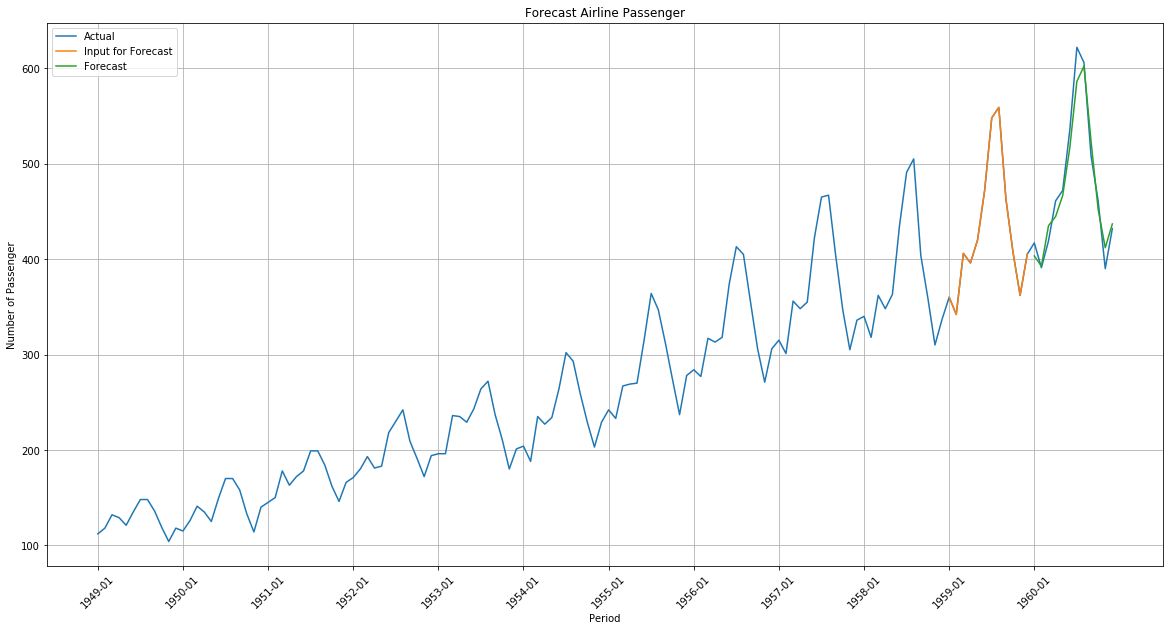

In [18]:
def predict2(model,predictPassengersX,forecast_size,filter):
    result=None
    predictInputPassengers=np.array(predictPassengersX)
    for loop in range(0,forecast_size):
        predictInput=np.reshape(predictInputPassengers[0,filter],(1,-1))
        predictOutput=model.predict(predictInput)
        print("Loop {}: Input: {} --> Result: {}".format(loop,predictInput,predictOutput))
        result=predictOutput if result is None else np.append(result,predictOutput)
        predictInputPassengers=np.reshape(np.append(predictInputPassengers[-1,1:],predictOutput),(1,-1))
    return np.reshape(result,(1,-1))

predictY2=predict2(model2,passengersX,forecast_size,[0,1,10,11])
print("\r\nChart")
show_results(df,scaler.inverse_transform(passengersX),scaler.inverse_transform(predictY2))  